In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import pandas as pd

from utils import lev_sigma_mean_std

In [2]:
df = lev_sigma_mean_std()

/home/roberto/Projects/Quant finance/Leveraged ETFs/utils.py:39: RuntimeWarning: invalid value encountered in log
  np.cumsum(np.log((np.exp(drift + diffusion) - 1) * leverage + 1), axis=1)


In [ ]:
def plot_heat_lev_sigma_mean(df):
    plt.figure(figsize=(8, 6))

    # We use a scatter plot where the 'hue' is the function output
    sns.scatterplot(
        data=df, x="leverage", y="sigma", hue="mean", palette="coolwarm", edgecolor=None
    )

    plt.title("average return lETF - underlying")
    plt.show()


def plot_heat_lev_sigma_std(df):
    plt.figure(figsize=(8, 6))

    # We use a scatter plot where the 'hue' is the function output
    sns.scatterplot(
        data=df, x="leverage", y="sigma", hue="std", palette="coolwarm", edgecolor=None
    )

    plt.title("standard deviation of lETF - underlying")
    plt.show()

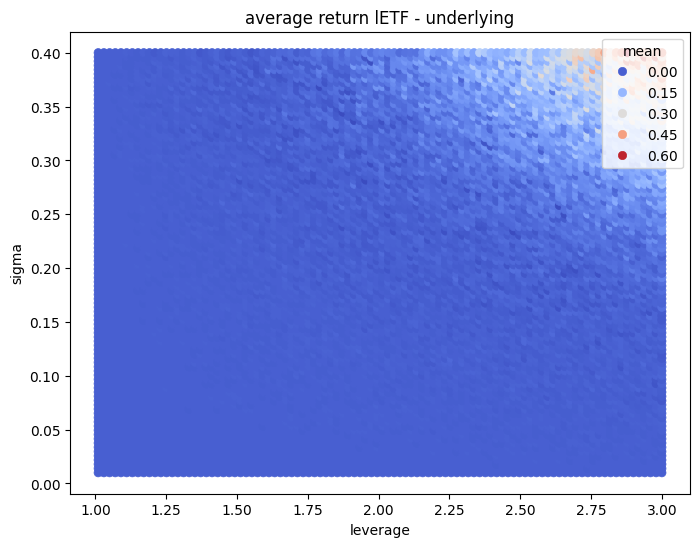

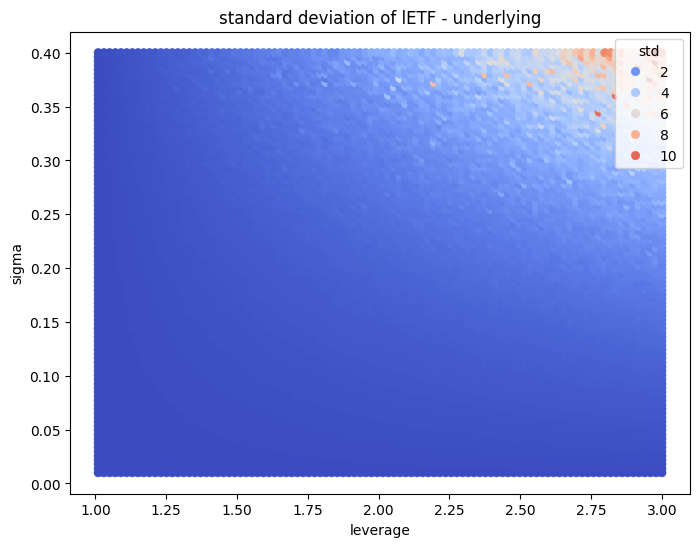

In [4]:
plot_heat_lev_sigma_mean(df)
plot_heat_lev_sigma_std(df)

In [5]:
def plot_surface_lev_sigma_std(df):
    # 1. Reconstruct the 1D axes from the dataframe
    # We sort them to ensure the grid aligns correctly
    leverages_1d = np.sort(df["leverage"].unique())
    sigmas_1d = np.sort(df["sigma"].unique())

    # 2. Reshape the 'z' data back into a 2D grid
    # index=y (rows), columns=x (cols)
    z_matrix = df.pivot(index="sigma", columns="leverage", values="std").values

    # 3. Create the interactive surface
    fig = go.Figure(
        data=[
            go.Surface(
                x=leverages_1d,  # The 1D array of leverage leverages
                y=sigmas_1d,  # The 1D array of sigmas
                z=z_matrix,  # The 2D grid of results
                colorscale="RdBu",
                colorbar=dict(title="log std diff"),
            )
        ]
    )

    fig.update_layout(
        title="Log std of lETF - underlying",
        scene=dict(
            xaxis_title="leverage",
            yaxis_title="sigma",
            zaxis_title="log std diff",
        ),
        width=750,
        height=650,
    )

    fig.show()

In [6]:
plot_surface_lev_sigma_std(df)

In [7]:
df.to_csv("output/lev_sigma_std.csv")

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

# 1. Prepare your features (X) and target (y)
# df has columns ['leverage', 'sigma', 'std']
X = df[["leverage", "sigma"]]
z = df["std"]

# 2. Create a pipeline: Polynomial Expansion -> Linear Regression
model = Pipeline(
    [("poly", PolynomialFeatures(degree=2)), ("linear", LinearRegression())]
)

# 3. Fit the model
model.fit(X, z)

# 4. Predict values (e.g., to see how well it fits)
df["std_fitted"] = model.predict(X)

In [9]:
df

,leverage,sigma,mean,std,std_fitted
0,1.01,0.010000,8.465066e-07,0.000222,1.031529
1,1.01,0.013939,-6.432290e-07,0.000309,0.987361
2,1.01,0.017879,-2.990306e-06,0.000403,0.943929
3,1.01,0.021818,-5.538841e-07,0.000489,0.901231
4,1.01,0.025758,1.100056e-06,0.000575,0.859269
...,...,...,...,...,...
9995,3.00,0.384242,3.850138e-01,8.596282,5.925268
9996,3.00,0.388182,4.177115e-01,7.782144,6.025085
9997,3.00,0.392121,4.613242e-01,7.911065,6.125638
9998,3.00,0.396061,3.292093e-01,6.862216,6.226926


In [ ]:
def plot_pred_lev_sigma_std(df):
    # 1. Reconstruct the 1D axes from the dataframe
    # We sort them to ensure the grid aligns correctly
    leverages_1d = np.sort(df["leverage"].unique())
    sigmas_1d = np.sort(df["sigma"].unique())

    # 2. Reshape the 'z' data back into a 2D grid
    # index=y (rows), columns=x (cols)
    z_matrix = df.pivot(index="sigma", columns="leverage", values="std").values
    pred_matrix = df.pivot(
        index="sigma", columns="leverage", values="std_fitted"
    ).values

    # 3. Create the interactive surface
    fig = go.Figure(
        data=[
            go.Surface(
                x=leverages_1d,  # The 1D array of leverage factors
                y=sigmas_1d,  # The 1D array of sigmas
                z=z_matrix,  # The 2D grid of results
                colorscale="RdBu",
                colorbar=dict(title="log std diff"),
            ),
            go.Surface(
                x=leverages_1d,  # The 1D array of leverage factors
                y=sigmas_1d,  # The 1D array of sigmas
                z=pred_matrix,  # The 2D grid of predictions
                # colorscale="RdBu",
                colorbar=dict(title="log std diff"),
            ),
        ]
    )

    fig.update_layout(
        title="Log std of lETF - underlying",
        scene=dict(
            xaxis_title="leverage",
            yaxis_title="sigma",
            zaxis_title="log std diff",
        ),
        width=750,
        height=650,
    )

    fig.show()

In [11]:
plot_pred_lev_sigma_std(df)

Proposed models:
- quadratic regression
- quadratic regression with weighted least squares
- quartic regression with fixing coefficients to have 0 at the boundary (doesn't address heteroskedacity): $(ax + bx^2)(cy + dy^2)$
- fit log(1 + std)

Do a 5-fold split with 5 generated dataframes, compute rmse for each model (new notebook).